In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Load data 

In [3]:
path_to_data = '../public_data/mixmhcpred/TableS2.txt'
# ignore the first row (header)
df = pd.read_csv(path_to_data, sep='\t', skiprows=1)

<Axes: >

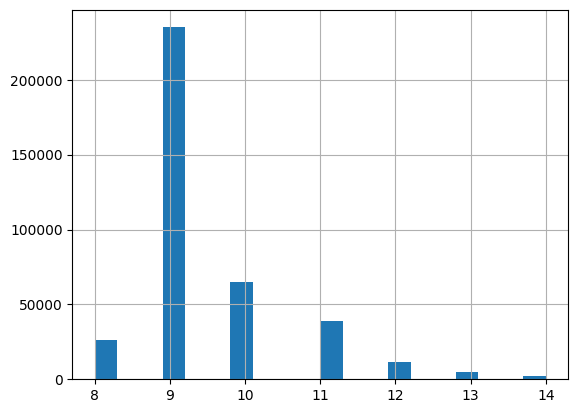

In [4]:
# length distributions of peptides
df['Peptide_Lengths'] = df['Peptide'].apply(len)
df['Peptide_Lengths'].hist(bins=20)

# Build XgBoost model for peptides with length of 8

In [5]:
df_8 = df[df['Peptide_Lengths'] == 8]

In [6]:
encoder = OneHotEncoder()

X_encoded = np.array([list(s) for s in df_8['Peptide'].values])
X_encoded = encoder.fit_transform(X_encoded).toarray()


In [7]:
label_encoder = LabelEncoder()
# Fit the encoder on your class labels and transform them into numerical labels
y_labeled = label_encoder.fit_transform(df_8['Allele'].values)

In [8]:
test_size = 0.2

# Calculate the number of samples in the test set
num_test_samples = int(test_size * len(X_encoded))

# Create an array of indices for shuffling
indices = np.arange(len(X_encoded))

# Randomly shuffle the indices
np.random.seed(20)
np.random.shuffle(indices)

# Split the shuffled indices into train and test sets
train_indices = indices[num_test_samples:]
test_indices = indices[:num_test_samples]

In [9]:
X_train_encoded = X_encoded[train_indices]
X_test_encoded = X_encoded[test_indices]
y_train_labeled = y_labeled[train_indices]
y_test_labeled = y_labeled[test_indices]

In [10]:
num_classes = len(np.unique(df_8['Allele']))
model_l8 = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    max_depth=3,
    learning_rate=0.1,
    n_estimators=200
)

# Train the model while monitoring the evaluation metrics
model_l8.fit(
    X_train_encoded, y_train_labeled,
    eval_metric=["mlogloss"],  # List of metrics to evaluate
    eval_set=[(X_train_encoded, y_train_labeled), (X_test_encoded, y_test_labeled)],  # Datasets for evaluation
    verbose=True
)


/usr/local/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:3.48110	validation_1-mlogloss:3.48269
[1]	validation_0-mlogloss:3.22192	validation_1-mlogloss:3.23243
[2]	validation_0-mlogloss:3.03191	validation_1-mlogloss:3.04814
[3]	validation_0-mlogloss:2.88342	validation_1-mlogloss:2.90466
[4]	validation_0-mlogloss:2.76317	validation_1-mlogloss:2.78896
[5]	validation_0-mlogloss:2.65818	validation_1-mlogloss:2.68870
[6]	validation_0-mlogloss:2.56908	validation_1-mlogloss:2.60490
[7]	validation_0-mlogloss:2.49039	validation_1-mlogloss:2.53060
[8]	validation_0-mlogloss:2.41902	validation_1-mlogloss:2.46356
[9]	validation_0-mlogloss:2.35573	validation_1-mlogloss:2.40483
[10]	validation_0-mlogloss:2.29900	validation_1-mlogloss:2.35157
[11]	validation_0-mlogloss:2.24619	validation_1-mlogloss:2.30288
[12]	validation_0-mlogloss:2.19865	validation_1-mlogloss:2.25964
[13]	validation_0-mlogloss:2.15494	validation_1-mlogloss:2.21876
[14]	validation_0-mlogloss:2.11284	validation_1-mlogloss:2.17991
[15]	validation_0-mlogloss:2.07494	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=117,
              num_parallel_tree=None, ...)

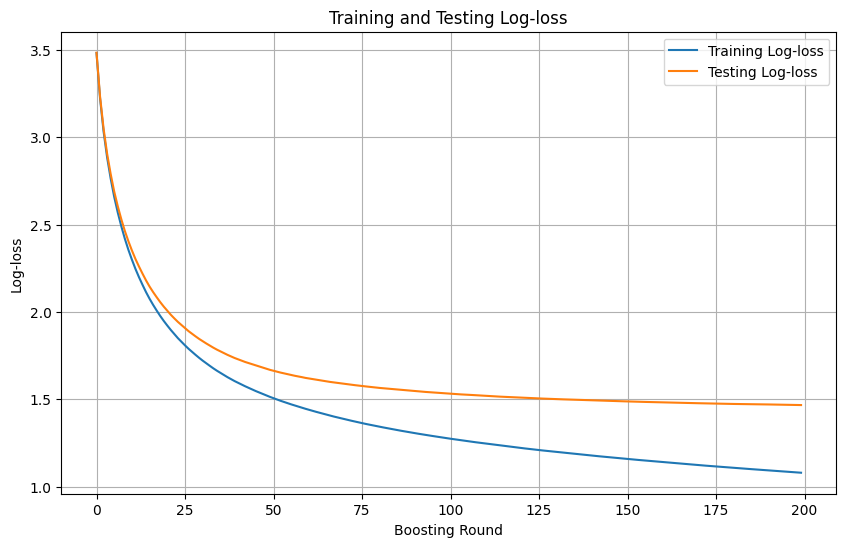

In [11]:
# Get the evaluation results for both training and validation sets
results = model_l8.evals_result()

# Extract log-loss values
train_logloss = results["validation_0"]["mlogloss"]
test_logloss = results["validation_1"]["mlogloss"]

# Plot log-loss
plt.figure(figsize=(10, 6))
plt.plot(train_logloss, label="Training Log-loss")
plt.plot(test_logloss, label="Testing Log-loss")
plt.xlabel("Boosting Round")
plt.ylabel("Log-loss")
plt.title("Training and Testing Log-loss")
plt.legend()
plt.grid(True)
plt.show()

Compare to MixMHCpred

In [12]:
test_peptides = df_8.iloc[test_indices]['Peptide']

In [14]:
test_peptides_file = "/Users/halasadi/code/pmhc_methods_tf/analysis/test_peptides.fasta"

# Open the output file for writing
with open(test_peptides_file, "w") as fasta_file:
    for peptide in test_peptides:
        # Write the peptide name as the header line starting with ">"
        fasta_file.write(f">{peptide}\n")
        fasta_file.write(f"{peptide}\n")


In [16]:
import subprocess

out_file = '/Users/halasadi/code/pmhc_methods_tf/analysis/out.txt'
command = ["/Users/halasadi/code/MixMHCpred-master/MixMHCpred", "-i", test_peptides_file, '-o', out_file, '-a', ",".join(np.unique(df_8['Allele'].values))]
try:
    output = subprocess.check_output(command, stderr=subprocess.STDOUT, universal_newlines=True)
except subprocess.CalledProcessError as e:
    print(f"Command failed with return code {e.returncode}")

In [38]:
y_pred = model_l8.predict(X_test_encoded)
pred_labels = label_encoder.inverse_transform(y_pred)
true_labels = label_encoder.inverse_transform(y_test_labeled)
accuracy = accuracy_score(pred_labels, true_labels)
print(f"Accuracy of XgBoost: {accuracy}")

pred_p = model_l8.predict_proba(X_test_encoded)
max_p = np.amax(pred_p, axis=1)
accuracy = accuracy_score(pred_labels[max_p > 0.9], true_labels[max_p > 0.9])
print(f"Accuracy of High Confidence XgBoost Calls: {accuracy}")

Accuracy of XgBoost: 0.573820395738204
Accuracy of High Confidence XgBoost Calls: 0.9574944071588367


In [27]:
df_out = pd.read_csv(out_file, sep='\t', comment='#')
mixmhcpredout = df_out[['Peptide', 'BestAllele']]
df_8_test = df_8.iloc[test_indices][['Peptide', "Allele"]]
mixmhcpredout = mixmhcpredout.merge(df_8_test, on = "Peptide", how = "left")
accuracy = accuracy_score(mixmhcpredout['Allele'], mixmhcpredout['BestAllele'])
print(f"Accuracy of MixMHCPred: {accuracy}")

Accuracy of MixMHCPred: 0.5232046070460704


It looks like our XgBoost model beats the PWM approach by a noticeable margin!

# Build XgBoost model for peptides with length of 9

Here we will use our XgBoost model from 